<a href="https://colab.research.google.com/github/BeileiCui/notebooks/blob/main/dinov2_depth_estimation_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Estimation

In [ ]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "/mnt/data-hdd/beilei/dinov2" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

## Download Data

In [ ]:
import gdown
import os

url = 'https://drive.google.com/uc?id=1jwXM_71qgQaVWQjVgCQmftJyvElK-LxI'
#https://drive.google.com/file/d/1jwXM_71qgQaVWQjVgCQmftJyvElK-LxI/view?usp=sharing
gdown.download(url,'SCARED.zip',quiet=True)

os.makedirs('SCARED/', exist_ok=True)
!unzip -q SCARED.zip -d SCARED/

4988.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Define Functions

In [ ]:
import os
import torch
import numpy as np
import sys
from scipy import stats

import torch.nn.functional as F
from PIL import Image
import matplotlib
from torchvision import transforms

import math
import itertools

class BadPixelMetric:
    def __init__(self, threshold=1.25, depth_cap=150):
        self.__threshold = threshold
        self.__depth_cap = depth_cap

    def compute_scale_and_shift(self, prediction, target, mask):
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = torch.sum(mask * prediction * prediction, (1, 2))
        a_01 = torch.sum(mask * prediction, (1, 2))
        a_11 = torch.sum(mask, (1, 2))

        # right hand side: b = [b_0, b_1]
        b_0 = torch.sum(mask * prediction * target, (1, 2))
        b_1 = torch.sum(mask * target, (1, 2))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = torch.zeros_like(b_0)
        x_1 = torch.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

    def __call__(self, prediction, target, mask):
        # transform predicted disparity to aligned depth
        target_disparity = torch.zeros_like(target)
        target_disparity[mask == 1] = 1.0 / target[mask == 1]

        scale, shift = self.compute_scale_and_shift(prediction, target_disparity, mask)
        prediction_aligned = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        disparity_cap = 1.0 / self.__depth_cap
        prediction_aligned[prediction_aligned < disparity_cap] = disparity_cap

        prediciton_depth = 1.0 / prediction_aligned

        # bad pixel
        err = torch.zeros_like(prediciton_depth, dtype=torch.float)

        err[mask == 1] = torch.max(
            prediciton_depth[mask == 1] / target[mask == 1],
            target[mask == 1] / prediciton_depth[mask == 1],
        )

        err[mask == 1] = (err[mask == 1] > self.__threshold).float()

        p = torch.sum(err, (1, 2)) / torch.sum(mask, (1, 2))

        return 100 * torch.mean(p), prediciton_depth

class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output

def compute_CIs(sample, alpha=0.05):
    mean = np.mean(sample)
    std = np.std(sample, ddof=1)

    dof = len(sample) - 1

    interval = stats.t.interval(alpha, dof, loc=mean, scale=std / np.sqrt(len(sample)))

    return interval

def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred)**2) / gt)

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)

    return silog, log10, abs_rel, sq_rel, rmse, rmse_log, d1, d2, d3

def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])



## Prepare Dataloader

SCARED dataset, lengths 553


(<Axes: >, <matplotlib.image.AxesImage at 0x7f66ea272100>)

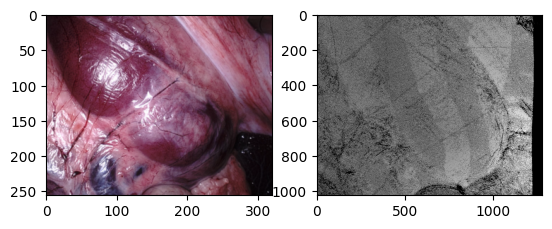

In [ ]:
from torch.utils.data import Dataset
from glob import glob
import cv2
import matplotlib.pyplot as plt

class SCAREDDataset(Dataset):
    def __init__(
        self,
        root,
        target_W,
        target_H,
        cap_depth=150,
    ):
        self.root = root

        self.cap_depth = cap_depth

        self.scans = []

        path_depth_all = glob(os.path.join(self.root, 'SCARED/*.tiff'))
        path_image_all = glob(os.path.join(self.root, 'SCARED/*.png'))
        path_depth_all.sort()
        path_image_all.sort()

        for image_path in path_image_all:
                filename = os.path.basename(image_path)
                sequence = filename[1]
                keyframe = filename[3]
                frame_id = filename[10:16]
                side = "left"

                data_splt = "train" if int(sequence) < 8 else "test"
                self.scans.append({
                        "data_splt": data_splt,
                        "sequence": sequence,
                        "keyframe": keyframe,
                        "frame_id": "{:06d}".format(int(frame_id)),
                        "side": side
                    })
        self.img_W = target_W
        self.img_H = target_H

        print("SCARED dataset, lengths", len(self.scans))


    def __getitem__(self, index):
        scan = self.scans[index]
        data_splt = scan['data_splt']
        sequence = scan['sequence']
        keyframe = scan['keyframe']
        frame_id = scan['frame_id']
        side = scan['side']


        img_path = os.path.join(self.root, "SCARED", "d{}k{}_{}_{}.png".format(sequence, keyframe, side, frame_id))
        depth_path = os.path.join(self.root, "SCARED", "d{}k{}_{}_depth_{}.tiff".format(sequence, keyframe, side, frame_id))

        img = self.read_rgb(img_path, self.img_W, self.img_H)
        depth = self._read_depth(depth_path, self.cap_depth)

        data = {
            "sequence": sequence,
            "keyframe": keyframe,
            "frame_id": frame_id,

            "image": img,
            "depth": depth
        }
        return data

    def __len__(self):
        return len(self.scans)


    def read_rgb(self, path, img_W, img_H, aug=False):

        # img = cv2.imread(path)
        # img = cv2.resize(img, (img_W, img_H), interpolation=cv2.INTER_CUBIC)

        # if img.ndim == 2:
        #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

        img = Image.open(path).convert("RGB")
        # # print(img.size)  # (W, H)
        img = img.resize((img_W, img_H), Image.Resampling.BILINEAR)
        # # PIL to numpy
        img = np.array(img, dtype=np.float32, copy=False) / 255.0

        return img


    @staticmethod
    def _read_depth(depth_filename, cap_depth=150):

        depth = cv2.imread(depth_filename,2)
        # depth = np.asarray(depth)
        # depth[depth > cap_depth] = cap_depth

        return depth

root = './'
dataset_scared = SCAREDDataset(
        root,
        target_W = 320,
        target_H = 256
    )

plt.subplot(121), plt.imshow(dataset_scared[0]["image"])
plt.subplot(122), plt.imshow(dataset_scared[0]["depth"], cmap='gray')



## Run evaluation

In [ ]:
import torch.utils.data as data
from dinov2.eval.depth.models import build_depther
from tqdm import tqdm
import argparse

import urllib
import itertools
from functools import partial
import mmcv
from mmcv.runner import load_checkpoint

def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()

def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

def build_model(backbone_size = "giant", head_dataset = "nyu", head_type = "dpt"):

    # backbone_size in ("small", "base", "large" or "giant")
    # head_dataset in ("nyu", "kitti")
    # head_type in ("linear", "linear4", "dpt")
    backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
    }

    backbone_arch = backbone_archs[backbone_size]
    backbone_name = f"dinov2_{backbone_arch}"

    backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
    backbone_model.eval()
    backbone_model.cuda()

    DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
    head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{head_dataset}_{head_type}_config.py"
    head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{head_dataset}_{head_type}_head.pth"

    cfg_str = load_config_from_url(head_config_url)
    cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

    model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=backbone_size,
    head_type=head_type,
    )

    load_checkpoint(model, head_checkpoint_url, map_location="cpu")
    model.eval()
    model.cuda()

    return model

def run(input_path, output_path, use_alignment=True, eval=True):
    """Run MonoDepthNN to compute depth maps.

    Args:
        input_path (str): path to input folder
        output_path (str): path to output folder
        use_alignment (bool): use depth alignment
        eval (bool): evaluate the output
    """
    print("initialize")

    # select device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device: %s" % device)

    # load network
    BACKBONE_SIZE = "giant" # in ("small", "base", "large" or "giant")
    HEAD_DATASET = "nyu" # in ("nyu", "kitti")
    HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")

    model = build_model(backbone_size = BACKBONE_SIZE, head_dataset = HEAD_DATASET, head_type = HEAD_TYPE)

    # load data
    ds = SCAREDDataset(input_path, target_W = 640, target_H = 512)
    dl = data.DataLoader(ds, batch_size=1, num_workers=1, shuffle=False, pin_memory=True)

    transform = make_depth_transform()
    img_shape = [1024,1280]

    if use_alignment:
        metric = BadPixelMetric(depth_cap=150)

    if eval:
        num_samples = len(ds)

        silog = np.zeros(num_samples, np.float32)
        log10 = np.zeros(num_samples, np.float32)
        rms = np.zeros(num_samples, np.float32)
        log_rms = np.zeros(num_samples, np.float32)
        abs_rel = np.zeros(num_samples, np.float32)
        sq_rel = np.zeros(num_samples, np.float32)
        d1 = np.zeros(num_samples, np.float32)
        d2 = np.zeros(num_samples, np.float32)
        d3 = np.zeros(num_samples, np.float32)

    # create output folder
    pred_output_path = os.path.join(output_path,"pred_depth")
    vis_output_path = os.path.join(output_path,"vis_depth")
    os.makedirs(pred_output_path, exist_ok=True)
    os.makedirs(vis_output_path, exist_ok=True)

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dl)):
            # print("  processing ({}/{})".format(i + 1, len(ds)))

            # to device
            img = np.array(batch["image"].squeeze(0))
            depth = np.array(batch["depth"].squeeze(0))
            # depth[depth <=0] = depth.max()

            transformed_image = transform(img)
            sample = transformed_image.unsqueeze(0).cuda()

            with torch.inference_mode():
                prediction = model.whole_inference(sample, img_meta=None, rescale=True)

            # depth_image = render_depth(prediction.squeeze().cpu())

            prediction = F.interpolate(
                prediction,
                size=img_shape,
                mode="bilinear",
                align_corners=False,
            )

            prediction = prediction.squeeze().cpu().numpy()
            mask = np.zeros_like(depth)
            mask[depth > 0] = 1

            ## alignment

            if use_alignment:
                inv_prediction = 1/prediction
                loss, aligned_prediciton_depth = metric(torch.from_numpy(inv_prediction).unsqueeze(0), torch.from_numpy(depth).unsqueeze(0), torch.from_numpy(mask).unsqueeze(0))
                aligned_prediciton_depth = aligned_prediciton_depth.squeeze().cpu().numpy()
                prediction = aligned_prediciton_depth
            ##

            if eval:
                valid_mask = np.array(mask, dtype=bool)
                silog[i], log10[i], abs_rel[i], sq_rel[i], rms[i], log_rms[i], d1[i], d2[i], d3[i] = compute_errors(depth[valid_mask], prediction[valid_mask])
                # silog[i], log10[i], abs_rel[i], sq_rel[i], rms[i], log_rms[i], d1[i], d2[i], d3[i] = compute_errors(depth[valid_mask], aligned_prediciton_depth[valid_mask])
            vis_pred = render_depth(prediction)
            # vis_pred = render_depth(aligned_prediciton_depth)

            pred_file_name = os.path.join(pred_output_path, "d" + batch["sequence"][0] + "k" +  batch["keyframe"][0] + "_pred_depth_" + batch["frame_id"][0] + ".tiff")
            vis_file_name = os.path.join(vis_output_path, "d" + batch["sequence"][0] + "k" +  batch["keyframe"][0] + "_vis_pred_depth_" + batch["frame_id"][0] + ".png")

            cv2.imwrite(pred_file_name,prediction)
            vis_pred.save(vis_file_name)

    if eval:

        CI_abs_rel = compute_CIs(abs_rel)
        CI_sq_rel = compute_CIs(sq_rel)
        CI_rms = compute_CIs(rms)
        CI_log_rms = compute_CIs(log_rms)
        CI_d1 = compute_CIs(d1)

        print("{:>7},       95% CIs,     {:>7},      95% CIs,     {:>7},      95% CIs,     {:>7},      95% CIs,     {:>7}, {:>7}, {:>7},         95% CIs,    {:>7}, {:>7}".format(
            'AbsRel', 'SqRel', 'RMSE', 'RMSElog', 'SILog', 'log10', 'd1', 'd2', 'd3'))
        print("{:7.3f}, [{:7.3f},{:7.3f}], {:7.3f}, [{:7.3f},{:7.3f}], {:7.3f}, [{:7.3f},{:7.3f}], {:7.3f}, [{:7.3f},{:7.3f}], {:7.3f}, {:7.3f}, {:7.3f}, [{:7.3f},{:7.3f}], {:7.3f}, {:7.3f}".format(
            abs_rel.mean(), CI_abs_rel[0], CI_abs_rel[1], sq_rel.mean(), CI_sq_rel[0], CI_sq_rel[1],
            rms.mean(), CI_rms[0], CI_rms[1], log_rms.mean(), CI_log_rms[0], CI_log_rms[1],
            silog.mean(), log10.mean(),
            d1.mean(), CI_d1[0], CI_d1[1], d2.mean(), d3.mean()))

    print("finished")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument("-i", "--input_path", default="./", help="folder with input images")
    parser.add_argument("-o", "--output_path", default="./output", help="folder for output images",)
    parser.add_argument("--use_alignment", default=True, help="use depth alignment")
    parser.add_argument("--eval", default=True, help="evaluate model at the same time")

    # args = parser.parse_args()
    args = parser.parse_args(args=[])

    # set torch options
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    # compute depth maps
    run(
        args.input_path,
        args.output_path,
        args.use_alignment,
        args.eval,
    )

initialize
device: cuda


Using cache found in /home/ren4/.cache/torch/hub/facebookresearch_dinov2_main


load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_nyu_dpt_head.pth
SCARED dataset, lengths 553


553it [05:38,  1.63it/s]

 AbsRel,       95% CIs,       SqRel,      95% CIs,        RMSE,      95% CIs,     RMSElog,      95% CIs,       SILog,   log10,      d1,         95% CIs,         d2,      d3
  0.067, [  0.067,  0.068],   0.533, [  0.532,  0.534],   5.494, [  5.487,  5.501],   0.090, [  0.090,  0.090],   8.961,   0.029,   0.968, [  0.968,  0.968],   0.997,   1.000
finished
